# Definition of successful computer games for the next year

For the Strimchik online store that sells computer games, it is necessary to find patterns that make the game successful. Information for past years is available from the input data. According to it, you need to determine which ads you need to run in which regions. And what games will be popular next year

## General information

In [1]:
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st

In [2]:
data = pd.read_csv("/datasets/games.csv")
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


## Data preparation

In [3]:
#Replacing column names
data = data.rename(columns = {'Name':'name', 'Platform': 'platform', 'Year_of_Release': 'year_of_release', 'Genre': 'genre', 'NA_sales': 'na_sales', 'EU_sales': 'eu_sales', 'JP_sales': 'jp_sales', 'Other_sales': 'other_sales', 'Critic_Score':'critic_score', 'User_Score': 'user_score', 'Rating': 'rating'}, inplace = False)

In [4]:
# Replacing the value type with Int
data['year_of_release'] = data['year_of_release'].astype('Int64')
data['critic_score'] = data['critic_score'].astype('Int64')

In [5]:
print(f'Number of games: {data.reset_index().name.nunique()}')
print(data['rating'].value_counts())
15/11559

Number of games: 11559
E       3990
T       2961
M       1563
E10+    1420
EC         8
K-A        3
RP         3
AO         1
Name: rating, dtype: int64


0.0012976901116013497

In [6]:
# Remove too rare values. (They will affect the final result)
data = data.drop(data[data.rating == 'EC' ].index) 
data = data.drop(data[data.rating == 'RP'].index)
data = data.drop(data[data.rating == 'K-A'].index)
data = data.drop(data[data.rating == 'AO'].index)

In [7]:
data.dropna(subset = ['genre'], inplace = True) # remove gaps
data.loc[data['user_score'] == 'tbd', 'user_score'] = None # Change tbd value to None
data['user_score'] = data['user_score'].astype('float')

data['critic_score'] = data['critic_score'].fillna(value = -5) # replace missing values with -5 (it will be easy to find and exclude later)
data['user_score'] = data['user_score'].fillna(value = -5) # replace missing values with -5

***I replaced these values with -5 so that it would be easy to find and exclude them later***

***Reason for data replacement:***
    
- There are only 2 gaps in the genre column, so we remove them
- The user score column has the value tbd which means (to be determined later) so replace it with None
     after we replace all values of None with the median.
- In the user score column, replace the entire value of None with the median

- In the rating column, remove outliers. (There are too few games with such a rating)
- Also in the columns year of release, critic_score and user score we change the data type


In [8]:
data['all_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales'] # All sales
data['all_sales'].head(10)

0    82.54
1    40.24
2    35.52
3    32.77
4    31.38
5    30.26
6    29.80
7    28.91
8    28.32
9    28.31
Name: all_sales, dtype: float64

## Exploratory data analysis

Text(0.5, 1.0, 'Number of games sold by year')

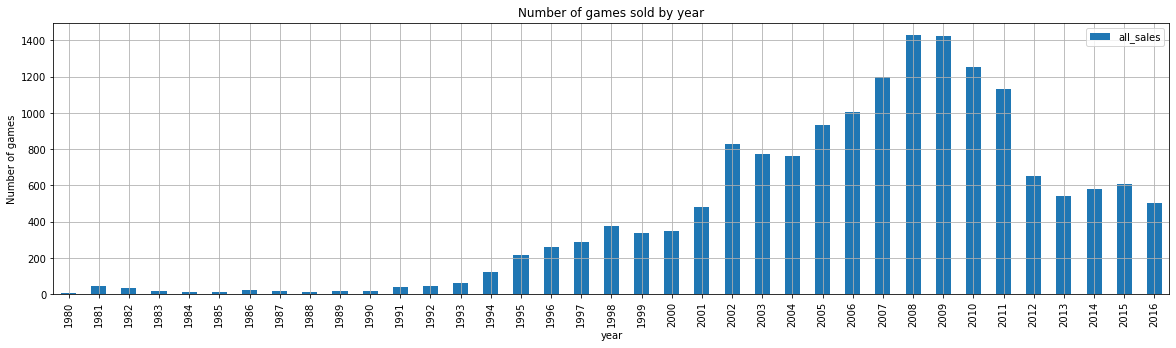

In [9]:
data.pivot_table(index="year_of_release", values="all_sales", aggfunc='count').plot(kind="bar", grid=True, figsize=(20, 5)) # Number of games sold by year
plt.xlabel('year')
plt.ylabel('Number of games')
plt.title('Number of games sold by year')

***Judging by the graph, data after 1994 is not very important to us***

In [10]:
# Sorting Platforms by year of game release
sails_year = data.pivot_table(index='year_of_release', columns='platform', values='all_sales', aggfunc='sum')
sails_year.fillna(0, inplace=True)


In [11]:
notnull=[] # Empty list
#Count the number of non-zero values for each prefix by years.
for platform in sails_year.columns:
    notnull.append(sails_year[platform].ne(0).value_counts().loc[sails_year[platform].ne(0).value_counts().index == True].values[0])
print(notnull)    

[10, 2, 6, 7, 11, 13, 8, 7, 5, 1, 7, 12, 4, 26, 1, 10, 12, 11, 4, 12, 6, 6, 2, 10, 1, 3, 11, 5, 12, 9, 4]


In [12]:
notnull = pd.DataFrame(notnull, columns=['seling']) # create a dataframe
notnull.describe() # find out the median

,seling
count,31.000000
mean,7.677419
std,5.081910
min,1.000000
25%,4.000000
50%,7.000000
75%,11.000000
max,26.000000


Text(0.5, 1.0, 'Number of consoles by year')

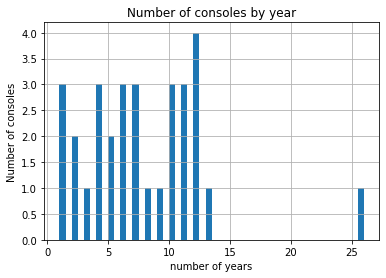

In [13]:
notnull.hist(bins=50) # Histogram
plt.xlabel('number of years')
plt.ylabel('Number of consoles')
plt.title('Number of consoles by year')

***Average release time for console games is about 7 years.***

In [14]:
# Top platforms by number of games sold
top = data.pivot_table(index='platform', values='all_sales', aggfunc='sum').sort_values('all_sales', ascending = False).head(10)
top

,all_sales
platform,
PS2,1255.53
X360,971.42
PS3,939.65
Wii,906.85
DS,805.47
PS,728.95
GBA,317.85
PS4,314.14
PSP,294.05


In [15]:
# Summary table of formats and games sold by years
for platform in sails_year.columns:
     if platform not in top.index:
         sails_year.drop(platform, axis=1, inplace=True)
sails_year = sails_year[sails_year.index >= 1994]
sails_year

platform,3DS,DS,GBA,PS,PS2,PS3,PS4,PSP,Wii,X360
year_of_release,,,,,,,,,,
1994,0.00,0.00,0.00,6.03,0.00,0.00,0.00,0.00,0.00,0.00
1995,0.00,0.00,0.00,35.96,0.00,0.00,0.00,0.00,0.00,0.00
1996,0.00,0.00,0.00,92.79,0.00,0.00,0.00,0.00,0.00,0.00
1997,0.00,0.00,0.00,136.17,0.00,0.00,0.00,0.00,0.00,0.00
1998,0.00,0.00,0.00,169.49,0.00,0.00,0.00,0.00,0.00,0.00
1999,0.00,0.00,0.00,144.53,0.00,0.00,0.00,0.00,0.00,0.00
2000,0.00,0.00,0.07,96.37,39.17,0.00,0.00,0.00,0.00,0.00
2001,0.00,0.00,61.53,35.59,166.43,0.00,0.00,0.00,0.00,0.00
2002,0.00,0.00,74.16,6.67,205.38,0.00,0.00,0.00,0.00,0.00


Text(0, 0.5, 'Pies Consumed')

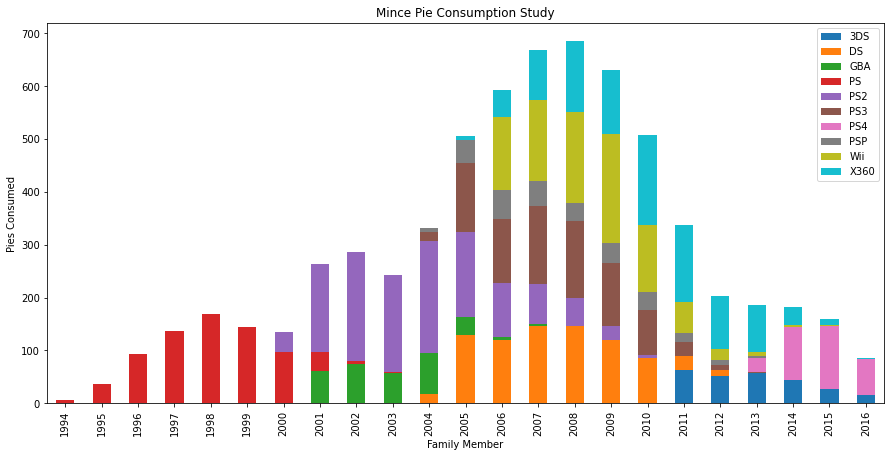

In [16]:
plotdata = pd.DataFrame({
    "3DS":sails_year['3DS'],
    "DS":sails_year['DS'],
    "GBA":sails_year['GBA'],
    "PS":sails_year['PS'],
    "PS2":sails_year['PS2'],
    "PS3":sails_year['PS3'],
    "PS4":sails_year['PS4'],
    "PS3":sails_year['DS'],
    "PSP":sails_year['PSP'],
    "Wii":sails_year['Wii'],
    "X360":sails_year['X360']
    }, 
    index=sails_year.index
)
plotdata.plot(kind='bar', stacked=True, figsize=(15, 7))
plt.title("Mince Pie Consumption Study")
plt.xlabel("Family Member")
plt.ylabel("Pies Consumed")

***The console on which games will be released in 2017 is PS4. To verify this, you can take data for the last 4 years (since the life of the console is usually 7 years)***

Text(0, 0.5, 'Pies Consumed')

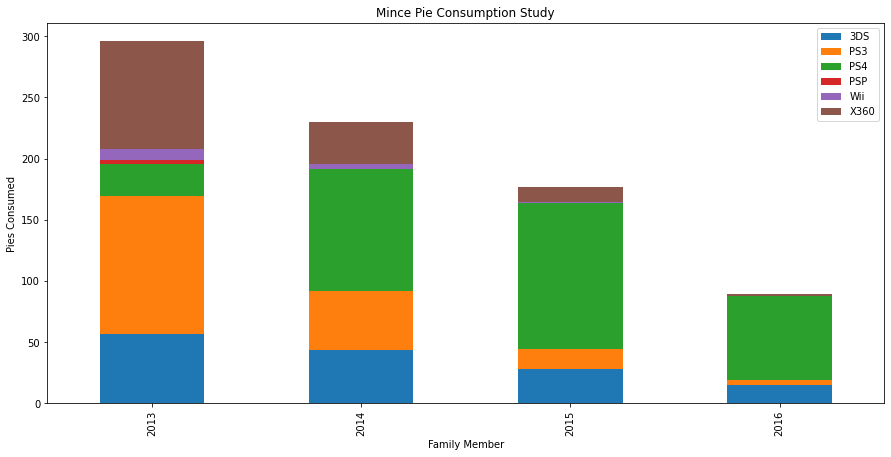

In [17]:
sails_13_17 = sails_year[sails_year.index >= 2013]

plotdata = pd.DataFrame({
    "3DS":sails_13_17['3DS'],
    "PS3":sails_13_17['PS3'],
    "PS4":sails_13_17['PS4'],
    "PSP":sails_13_17['PSP'],
    "Wii":sails_13_17['Wii'],
    "X360":sails_13_17['X360']
    }, 
    index=sails_13_17.index
)
plotdata.plot(kind='bar', stacked=True, figsize=(15, 7))
plt.title("Mince Pie Consumption Study")
plt.xlabel("Family Member")
plt.ylabel("Pies Consumed")

***Knowing that the average time for the release of games on the console is about 7 years, according to forecasts for 2017, the most relevant console will be PS4.***
- XBOX360, PS3,3DS, etc. have already exhausted their resources. I think some games will be released on the 3DS in 2017, but much less than on PS4

Text(0, 0.5, 'Prices')

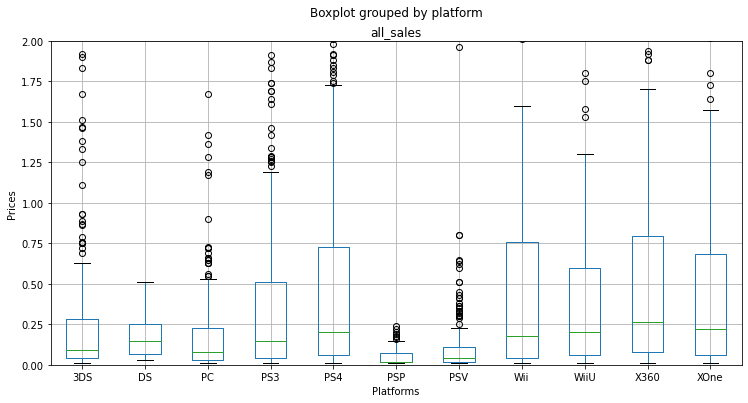

In [18]:
data_new = data[data['year_of_release'] >= 2013]
# Mustache box for each platform
data_new.boxplot(column = 'all_sales', by="platform", figsize=(12, 6))
plt.ylim(0, 2)
plt.xlabel('Platforms')
plt.ylabel('Prices')

In [19]:
data_new.pivot_table(index="platform", values= 'all_sales', aggfunc='sum')

,all_sales
platform,
3DS,143.25
DS,1.54
PC,39.43
PS3,181.43
PS4,314.14
PSP,3.50
PSV,32.99
Wii,13.66
WiiU,64.63


***It can be concluded that the most profitable platform is PS4, and the most unprofitable is PSP. Also in good demand are X360, PS3, XOne and 3DS.***

In [20]:
ps4 = data_new.query('(platform in "PS4") and (user_score != -5) and (critic_score != -5)') # PS4 only
ps4


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97,8.3,M,12.62
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82,4.3,E,8.58
92,Call of Duty: Advanced Warfare,PS4,2014,Shooter,2.81,3.48,0.14,1.23,83,5.7,M,7.66
94,FIFA 17,PS4,2016,Sports,0.66,5.75,0.08,1.11,85,5.0,E,7.60
105,Fallout 4,PS4,2015,Role-Playing,2.53,3.27,0.24,1.13,87,6.5,M,7.17
...,...,...,...,...,...,...,...,...,...,...,...,...
16486,Super Dungeon Bros,PS4,2016,Action,0.01,0.00,0.00,0.00,42,2.3,E10+,0.01
16499,Sherlock Holmes: The Devil's Daughter,PS4,2016,Adventure,0.01,0.00,0.00,0.00,70,6.8,T,0.01
16500,Root Letter,PS4,2016,Adventure,0.00,0.00,0.01,0.00,69,7.5,NaN,0.01
16526,Dungeons 2,PS4,2016,Role-Playing,0.01,0.00,0.00,0.00,61,7.9,T,0.01


(0.0, 20.0)

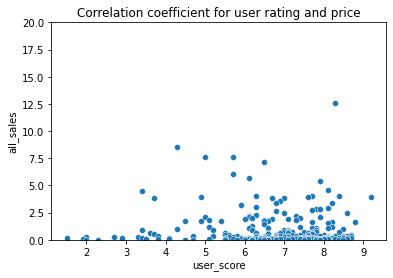

In [21]:
sns.scatterplot(data=ps4, x="user_score", y="all_sales")
plt.title('Correlation coefficient for user rating and price')
plt.ylim(0, 20)

(0.0, 20.0)

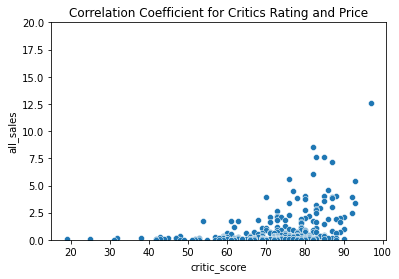

In [22]:
sns.scatterplot(data=ps4, x='critic_score' , y='all_sales')
plt.title('Correlation Coefficient for Critics Rating and Price')
plt.ylim(0, 20)

These graphs show much better that critic rating affects the price.

In [23]:
ps4.corr() # Correlation coefficient for PS4

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,all_sales
year_of_release,1.000000,-0.261760,-0.191355,-0.122830,-0.232177,-0.019983,0.150315,-0.234400
na_sales,-0.261760,1.000000,0.714988,0.530480,0.915292,0.414241,-0.022577,0.893807
eu_sales,-0.191355,0.714988,1.000000,0.519826,0.935136,0.346044,-0.050671,0.951656
jp_sales,-0.122830,0.530480,0.519826,1.000000,0.566734,0.322057,0.174512,0.592214
other_sales,-0.232177,0.915292,0.935136,0.566734,1.000000,0.408465,-0.037332,0.997798
critic_score,-0.019983,0.414241,0.346044,0.322057,0.408465,1.000000,0.557654,0.405895
user_score,0.150315,-0.022577,-0.050671,0.174512,-0.037332,0.557654,1.000000,-0.033625
all_sales,-0.234400,0.893807,0.951656,0.592214,0.997798,0.405895,-0.033625,1.000000


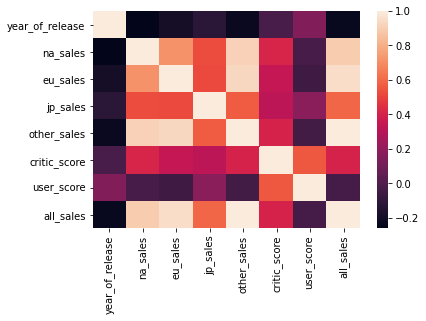

In [24]:
ax = sns.heatmap(ps4.corr())

***User ratings do not affect the number of games sold, and critic reviews do a little, but they do***
- correlation coefficients -0.06 and 0.34

In [25]:
actual_platforms = ["3DS", "PS3", "WiiU", "X360", "XOne"]
for platform in actual_platforms:
    print(data_new[data_new['platform']== platform].corr())

                 year_of_release  na_sales  eu_sales  jp_sales  other_sales  \
year_of_release         1.000000 -0.075933 -0.115177 -0.063487    -0.083695   
na_sales               -0.075933  1.000000  0.931893  0.641878     0.993708   
eu_sales               -0.115177  0.931893  1.000000  0.633982     0.958274   
jp_sales               -0.063487  0.641878  0.633982  1.000000     0.645306   
other_sales            -0.083695  0.993708  0.958274  0.645306     1.000000   
critic_score            0.005430  0.096662  0.074737 -0.003030     0.093406   
user_score             -0.002700  0.085173  0.070046 -0.035211     0.082845   
all_sales              -0.090086  0.938867  0.927821  0.854173     0.945649   

                 critic_score  user_score  all_sales  
year_of_release      0.005430   -0.002700  -0.090086  
na_sales             0.096662    0.085173   0.938867  
eu_sales             0.074737    0.070046   0.927821  
jp_sales            -0.003030   -0.035211   0.854173  
other_sales  

- critic_score\user_score
- 0.103681 / 0.065113
- 0.294214 / -0.085058
- 0.331536 / 0.338184
- 0.285467 / -0.044548
- 0.360451 / -0.105937

***There is only one console where user_score has more weight than critic_score is the Wii. It seems to me that this can be attributed to the replacement of data. Basically, the price is influenced by reviews from critics, and even then not very much ***

Text(0.5, 1.0, 'Relationship of sales to game genre')

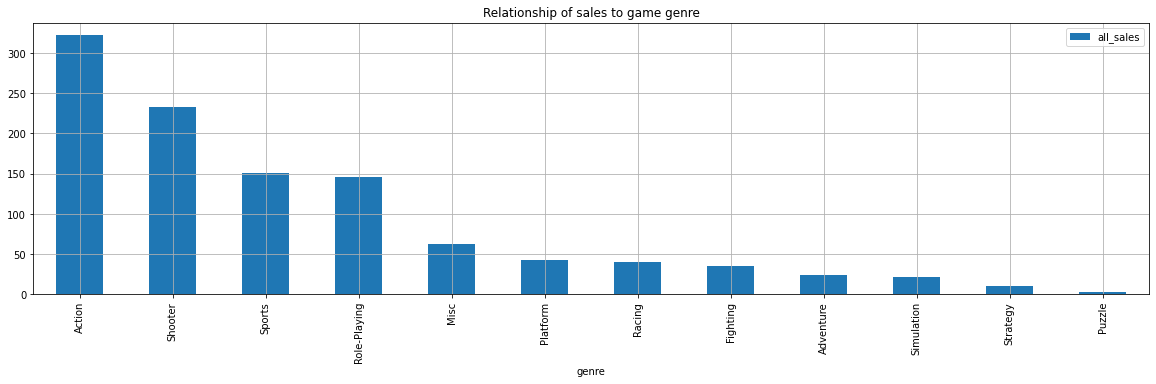

In [26]:
ganre_sales = data_new.pivot_table(index="genre", values= 'all_sales', aggfunc='sum' ).sort_values('all_sales', ascending = False)
ganre_sales.plot(kind="bar", grid=True, figsize=(20, 5))
plt.title('Relationship of sales to game genre')

***Favorites and outsiders are immediately visible among sales by genre. Action games are the most profitable, and shooters are not far behind them. The lowest margin genre is puzzles.***

In [27]:
data_new.pivot_table(index=['name', 'genre'], values='all_sales', aggfunc='sum').sort_values('all_sales', ascending = False).head(20)

,,all_sales
name,genre,
Grand Theft Auto V,Action,56.58
Call of Duty: Ghosts,Shooter,27.39
Call of Duty: Black Ops 3,Shooter,25.67
Minecraft,Misc,24.16
Call of Duty: Advanced Warfare,Shooter,21.97
FIFA 15,Sports,17.37
FIFA 14,Sports,16.46
FIFA 16,Sports,16.30
Pokemon X/Pokemon Y,Role-Playing,14.60


**If you sort games by best selling games, then the top 20 will have 1 action game, and a bunch of shooters.**

## User portrait of each region

In [28]:
# Most popular platforms by region
print('\nNorth America')
na_sales = data_new.pivot_table(index='platform', values='na_sales', aggfunc='sum').sort_values('na_sales', ascending = False).head(5)
na_sales_rate = na_sales['na_sales']/ na_sales['na_sales'].sum()
print(na_sales_rate)
print('\nEurope ')
eu_sales = data_new.pivot_table(index='platform', values='eu_sales', aggfunc='sum').sort_values('eu_sales', ascending = False).head(5)
eu_sales_rate = eu_sales['eu_sales']/ eu_sales['eu_sales'].sum()
print(eu_sales_rate)
print('\nJapan ')
jp_sales = data_new.pivot_table(index='platform', values='jp_sales', aggfunc='sum').sort_values('jp_sales', ascending = False).head(5)
jp_sales_rate = jp_sales['jp_sales']/ jp_sales['jp_sales'].sum()
print(jp_sales_rate)


North America
platform
PS4     0.282280
XOne    0.241732
X360    0.211983
PS3     0.164841
3DS     0.099164
Name: na_sales, dtype: float64

Europe 
platform
PS4     0.422463
PS3     0.203042
XOne    0.154475
X360    0.127317
3DS     0.092703
Name: eu_sales, dtype: float64

Japan 
platform
3DS     0.496449
PS3     0.170950
PSV     0.136101
PS4     0.116846
WiiU    0.079654
Name: jp_sales, dtype: float64


/tmp/ipykernel_101/3351904245.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(all_platforms)


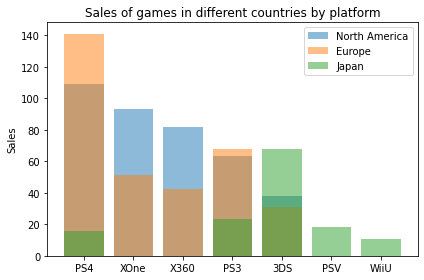

In [29]:
# All platforms
all_platforms = []
for i in na_sales.index:
     if i not in all_platforms:
        all_platforms.append(i)
for j in eu_sales.index:
     if j not in all_platforms:
        all_platforms.append(j)
for f in jp_sales.index:
     if f not in all_platforms:
        all_platforms.append(f)


fig, ax = plt.subplots()
rects1 = ax.bar(na_sales.index, na_sales['na_sales'], label='North America', alpha=0.5)
rects2 = ax.bar(eu_sales.index, eu_sales['eu_sales'], label='Europe', alpha=0.5)
rects2 = ax.bar(jp_sales.index, jp_sales['jp_sales'], label='Japan', alpha=0.5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Sales')
ax.set_title('Sales of games in different countries by platform')
ax.set_xticklabels(all_platforms)
ax.legend()

        

fig.tight_layout()

plt.show()

Text(0.5, 1.0, 'Number of games sold by year in NA')

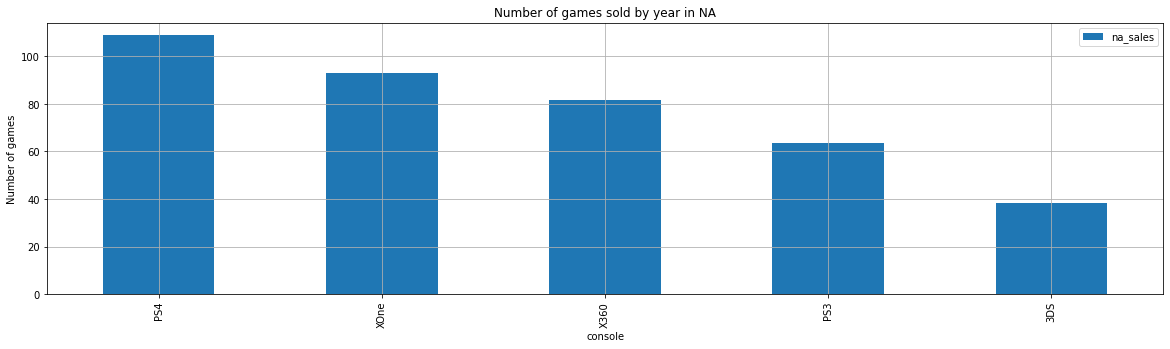

In [30]:
na_sales.plot(kind="bar", grid=True, figsize=(20, 5))
plt.xlabel('console')
plt.ylabel('Number of games')
plt.title('Number of games sold by year in NA')

Text(0.5, 1.0, 'Number of games sold by year in EU')

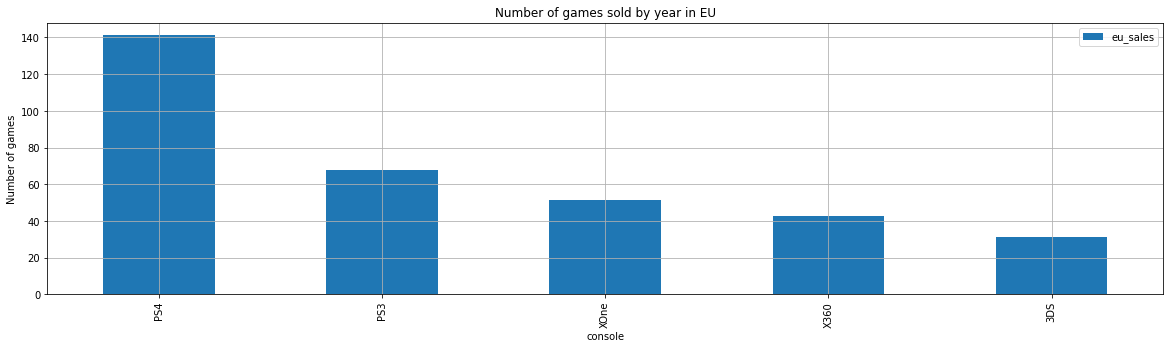

In [31]:
eu_sales.plot(kind="bar", grid=True, figsize=(20, 5))
plt.xlabel('console')
plt.ylabel('Number of games')
plt.title('Number of games sold by year in EU')

Text(0.5, 1.0, 'Number of games sold by year in JP')

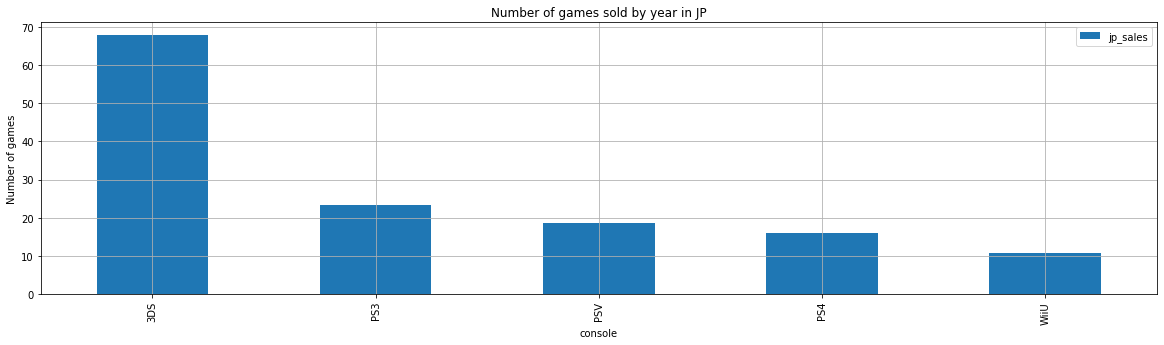

In [32]:
jp_sales.plot(kind="bar", grid=True, figsize=(20, 5))
plt.xlabel('console')
plt.ylabel('Number of games')
plt.title('Number of games sold by year in JP')

***In the case of America and Europe, the platforms are almost the same, but Japan, as usual, excelled. Moreover, the top 5 in Europe and America contain the same consoles, just in a different order, while in Japan PSV and WiiU are added.***

In [33]:
# Most popular genres by region
print('\nNorth America')
na_genre = data_new.pivot_table(index='genre', values='na_sales', aggfunc='sum').sort_values('na_sales', ascending = False).head(5)
na_genre_rate = na_genre['na_sales']/ na_genre['na_sales'].sum()
print(na_genre_rate)
print('\nEurope ')
eu_genre = data_new.pivot_table(index='genre', values='eu_sales', aggfunc='sum').sort_values('eu_sales', ascending = False).head(5)
eu_genre_rate = eu_genre['eu_sales']/ eu_genre['eu_sales'].sum()
print(eu_genre_rate)
print('\nJapan ')
jp_genre = data_new.pivot_table(index='genre', values='jp_sales', aggfunc='sum').sort_values('jp_sales', ascending = False).head(5)
jp_genre_rate = jp_genre['jp_sales']/ jp_genre['jp_sales'].sum()
print(jp_genre_rate)


North America
genre
Action          0.336178
Shooter         0.292679
Sports          0.174077
Role-Playing    0.123750
Misc            0.073316
Name: na_sales, dtype: float64

Europe 
genre
Action          0.364970
Shooter         0.271449
Sports          0.186981
Role-Playing    0.114221
Racing          0.062378
Name: eu_sales, dtype: float64

Japan 
genre
Role-Playing    0.443865
Action          0.352118
Misc            0.080007
Fighting        0.066528
Shooter         0.057483
Name: jp_sales, dtype: float64


/tmp/ipykernel_101/2451053391.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(all_platforms)


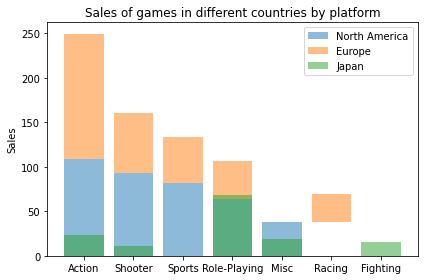

In [34]:
all_platforms = []
for i in na_genre.index:
     if i not in all_platforms:
        all_platforms.append(i)
for j in eu_genre.index:
     if j not in all_platforms:
        all_platforms.append(j)
for f in jp_genre.index:
     if f not in all_platforms:
        all_platforms.append(f)


fig, ax = plt.subplots()
rects1 = ax.bar(na_genre.index, na_sales['na_sales'], label='North America', alpha=0.5)
rects2 = ax.bar(eu_genre.index, eu_sales['eu_sales'],bottom = na_sales['na_sales'], label='Europe', alpha=0.5)
rects2 = ax.bar(jp_genre.index, jp_sales['jp_sales'], label='Japan', alpha=0.5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Sales')
ax.set_title('Sales of games in different countries by platform')
ax.set_xticklabels(all_platforms)
ax.legend()

        

fig.tight_layout()

plt.show()

***By genre, too, a similar situation. Although Action and Shooters are loved by everyone. Role-Playing and Fighting genres are very popular in Japan. Perhaps that is why the platforms differ. Also, Europeans are more into music and Americans are into Racing.***

In [35]:
data_new['rating'].value_counts()

M       369
T       333
E       302
E10+    252
Name: rating, dtype: int64

- M - **17 years and older**
- T - **13 years and older**
- E - **Kids to Adults**
- E10+ - **aged 10 years and older**

In [36]:
# Most popular genres by region
print('\nNorth America')
na_rating = data_new.pivot_table(index='rating', values='na_sales', aggfunc='sum').sort_values('na_sales', ascending = False)
na_rating = na_rating['na_sales'] / na_rating['na_sales'].sum()
print(na_rating)
print('\nEurope')
eu_rating = data_new.pivot_table(index='rating', values='eu_sales', aggfunc='sum').sort_values('eu_sales', ascending = False)
eu_rating = eu_rating['eu_sales'] / eu_rating['eu_sales'].sum()
print(eu_rating)
print('\nJapan')
jp_rating = data_new.pivot_table(index='rating', values='jp_sales', aggfunc='sum').sort_values('jp_sales', ascending = False)
jp_rating = jp_rating['jp_sales'] / jp_rating['jp_sales'].sum()
print(jp_rating)


North America
rating
M       0.474346
E       0.226966
E10+    0.155732
T       0.142956
Name: na_sales, dtype: float64

Europe
rating
M       0.463807
E       0.266054
E10+    0.136250
T       0.133889
Name: eu_sales, dtype: float64

Japan
rating
T       0.369460
E       0.271667
M       0.253185
E10+    0.105688
Name: jp_sales, dtype: float64


***According to this rating, we can conclude that among European and American gamers, the most common are people 17+, and in Japan it is mostly 13+. Although these data can not build a complete picture. The 2nd place is occupied by the E rating in all regions. The rating also clearly affects the purchase.***

## Testing hypotheses

In [37]:
xone = data_new.query('(platform == "PS4") and (user_score != -5) and (critic_score != -5)')['user_score']
pc = data_new.query('(platform == "PC") and (user_score != -5) and (critic_score != -5)')['user_score']

print(np.var(xone, ddof=1))
print(np.var(pc, ddof=1))


2.119042298225158
2.932444842801986


    This 'equal_var' parameter is used when the variances of the two samples are different. I also read an article about how best to leave this parameter set to False.


In [38]:
alpha = .05

results = st.ttest_ind(
     xone,
     pc,
     equal_var=False)

print('p-value:', results.pvalue)

if(results.pvalue<alpha):
     print("Reject the null hypothesis")
else:
     print("Failed to reject null hypothesis")

p-value: 0.00826569237189147
Reject the null hypothesis


- ***H0*** - User ratings are the same
- ***H1*** - User ratings vary

In [39]:
box_pc = data_new.query('platform in ("XOne", "PC") and (user_score != -5) and (critic_score != -5)')
box_pc.pivot_table(index='platform', values='user_score', aggfunc='mean')

,user_score
platform,
PC,6.302027
XOne,6.538182


- **We reject the hypothesis that the user rating on both platforms is the same.**
- ***If you look, the difference is quite large***


In [40]:
action = data_new.query('(genre == "Action") and (user_score != -5) and (critic_score != -5)')['user_score']
sports = data_new.query('(genre == "Sports") and (user_score != -5) and (critic_score != -5)')['user_score']

print(np.var(action, ddof=1))
print(np.var(sports, ddof=1))

1.6462144328163746
2.1316396997497913


In [41]:
alpha = .05

results = st.ttest_ind(
    action,
    sports,
    equal_var=False)

print('p-value:', results.pvalue)

if(results.pvalue<alpha):
     print("Reject the null hypothesis")
else:
     print("Failed to reject null hypothesis")

p-value: 1.0496920005008588e-13
Reject the null hypothesis


- ***H0*** - User ratings are the same
- ***H1*** - User ratings vary

In [42]:
action_sport = data.query('genre in ("Action", "Sports") and (user_score != -5) and (critic_score != -5)')
action_sport.pivot_table(index='genre', values='user_score', aggfunc='mean')

,user_score
genre,
Action,7.093317
Sports,7.105653


- **We reject the hypothesis that the user rating on both platforms is the same.**
- ***If you look, the difference is quite large. Users prefer action over sports***


## Conclusion

**We can conclude that in order for sales to go well, you need to sell games according to these criteria:**

- To be popular in the European or American market, the game must be developed for Xbox One and PS4, but for Japan, the game on the 3DS would be best.
- The best genre is Action. It suits everyone. Shooters are also popular for Europe and America, and role-play for Japan.
- The ESRB rating must be either 17 years old for America and Europe or 13 years old for Japan. The Kids to Adults ranking will also be a good decision, as it is in second place in all countries.

***There is no point in thinking about user ratings. But the reviews of critics are important.***

*Europe user portrait:*
 - Best PS4 and PS3 platform
 - The best genre is Action and Shooter
 - ESRB rating must be: M or E
 
 *America User Portrait:*
 - Best PS4 and XboxONE platform
 - The best genre is Action and Shooter
 - ESRB rating must be: M or E
 
 *Japan user portrait:*
 - Best platform 3DS and PS3
 - The best genre is Role-Playing and Action
 - ESRB rating must be: T or E